# K-Nearest Neighbors Classifier

## 1. Importing Libararies

In [37]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors, datasets
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split,KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, accuracy_score, classification_report, f1_score, average_precision_score, precision_recall_fscore_support

## 2. Importing data

In [46]:
# Reading data
raw_data= pd.read_csv("car.txt", header  = None, names = ['buying','maint','doors','persons','lug_boot','safety', 'class_evaluation'])

# Exploring data sturcture
raw_data.head()
raw_data.describe()
#raw_data.class_evaluation.unique()


,buying,maint,doors,persons,lug_boot,safety,class_evaluation
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,low,low,3,more,small,low,unacc
freq,432,432,432,576,576,576,1210


## I. RUN model with numeric data 

In [47]:
# Using numeric data to run model 

# Replacing target variable with 1 and 0 inplace of M and B
#raw_data.target.replace(to_replace= {"M": 1, "B": 0}, inplace=True)
raw_data["buying"].replace(to_replace ={"low":0,"med":1,"high":2,"vhigh":3}, inplace= True)
raw_data["maint"].replace(to_replace ={"low":0,"med":1,"high":2,"vhigh":3}, inplace= True)
raw_data["lug_boot"].replace(to_replace ={"small":0,"med":1,"big":2}, inplace= True)
raw_data["safety"].replace(to_replace ={"low":0,"med":1,"high":2}, inplace= True)
raw_data["doors"].replace(to_replace ={"2":0,"3":1,"4":2,"5more":3}, inplace= True)
raw_data["persons"].replace(to_replace ={"2":0,"4":1,"more":2}, inplace= True)
raw_data.head()


,buying,maint,doors,persons,lug_boot,safety,class_evaluation
0,3,3,0,0,0,0,unacc
1,3,3,0,0,0,1,unacc
2,3,3,0,0,0,2,unacc
3,3,3,0,0,1,0,unacc
4,3,3,0,0,1,1,unacc


## 3. Exploratory Data Analysis

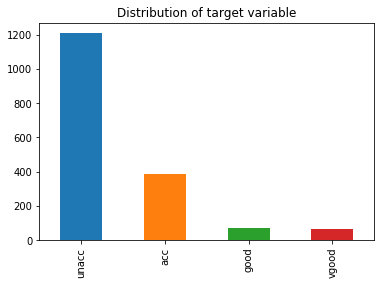

In [40]:
# Understanding distribution of target variable
raw_data["class_evaluation"].value_counts().plot("bar")
plt.title("Distribution of target variable")
plt.show() 

## 4. Treatments for training, validation and test data

In [48]:
# Splitting the raw data as train and test
x = raw_data.iloc[:, :6]
y = raw_data['class_evaluation']

# Splitting into train+val and test
trainval_x, test_x, trainval_y, test_y = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=1000)

#Splitting into train and validation using stratified sampling
#train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size = 0.125, stratify=trainval_y, random_state=1000)

# Printing the number of records for the train, test and validation sets
print("Dimensions of Train, Validation and Test split")
print("Train x:", trainval_x.shape)
print("Train y:", trainval_y.shape)
#print("Validation x:", val_x.shape)
#print("Validation y:", val_y.shape)
print("Test x:", test_x.shape)
print("Test y:", test_y.shape)

Dimensions of Train, Validation and Test split
Train x: (1382, 6)
Train y: (1382,)
Test x: (346, 6)
Test y: (346,)


In [49]:
# Standardization with respect to the 80% dataset (Training part of training and validation set)
scaler = StandardScaler()
scaler.fit(trainval_x)

trainval_x = scaler.transform(trainval_x)
test_x = scaler.transform(test_x)
#train_x = scaler.transform(train_x)
#val_x = scaler.transform(val_x)

## 5. Identifying  optimal hyperparameter(k) using cross-validation

In [50]:
#  Cross validation for hyperparameter tuning manually 
mean_v=[]
std_v=[]
for i in range(1, 21, 1):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(classifier, trainval_x, trainval_y, cv=10, scoring="accuracy")
    mean_v.append(scores.mean())
    std_v.append(scores.std())

print("k\tMean\tStd")
for num, i, j in zip(range(1, 21, 1), mean_v, std_v):
    print(num,'\t{0:.4f}\t{1:.4f}'.format(i, j))

k	Mean	Std
1 	0.9471	0.0271
2 	0.9159	0.0211
3 	0.9543	0.0212
4 	0.9333	0.0242
5 	0.9558	0.0118
6 	0.9529	0.0133
7 	0.9543	0.0206
8 	0.9478	0.0194
9 	0.9536	0.0194
10 	0.9500	0.0165
11 	0.9558	0.0157
12 	0.9500	0.0145
13 	0.9479	0.0129
14 	0.9443	0.0144
15 	0.9407	0.0148
16 	0.9421	0.0167
17 	0.9399	0.0165
18 	0.9356	0.0173
19 	0.9341	0.0128
20 	0.9334	0.0179


In [51]:
# grid search cross validation to find best hyperparameter automatically 
classifier2 = neighbors.KNeighborsClassifier()
k_range = range(1,20)
parameters = {'n_neighbors': k_range,
              'weights' : ['uniform', 'distance'],
             }

clf = GridSearchCV(classifier2, parameters, cv=10)

# Fitting the taining data 
clf.fit(trainval_x, trainval_y)
print(clf.best_params_)

# Accuracy on training data
print(clf.score(trainval_x,trainval_y))

{'n_neighbors': 6, 'weights': 'distance'}
1.0


In [57]:
#  Nested Cross validation for optimal hyperparameter= 6 
mean_v= []
std_v =[]
NUM_TRIALS = 10
for j in range(NUM_TRIALS):
        classifier = neighbors.KNeighborsClassifier(n_neighbors =6)
        outer_cv = KFold(n_splits=4, shuffle=True, random_state=j)
        scores = cross_val_score(classifier, trainval_x, trainval_y, cv=outer_cv, scoring="accuracy")
        mean_v.append(scores.mean())
        std_v.append(scores.std())
        
print(mean_v)

[0.9493612297897294, 0.9348810421378906, 0.9471747507749015, 0.9327113177515288, 0.9413902152969758, 0.9298253329982408, 0.9413818379827428, 0.9261749183211863, 0.9312620423892102, 0.9471768451034598]


From the cross validation, we can see that the k= 5-11 have highest means around 95%.
Then we run the grid search cross validation from k= 1- 20; automatically it gives us the best parameter, which is 6, with 100%. Running many trials o cross validation, the accuracy ratios stay around 94%. With all above observations, we choose k= 6.  

## 7. Final model training and evaluation

In [58]:
# Using k = 6 for predicting on test to find accuracy
classifier = neighbors.KNeighborsClassifier(n_neighbors = 6)
classifier.fit(trainval_x, trainval_y)

# Validation
pred_test_y = classifier.predict(test_x)

# Results of classification - Confusion matrix, precision, recall and F1-score
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_test_y))
#print("\nF1-score = {0:.4f}\n".format(f1_score(test_y, pred_test_y, pos_label=1, average='binary')))
print("\nClassification Report")
print(classification_report(test_y, pred_test_y))


Confusion Matrix
[[ 75   1   1   0]
 [  6   8   0   0]
 [  3   0 239   0]
 [  4   0   0   9]]

Classification Report
             precision    recall  f1-score   support

        acc       0.85      0.97      0.91        77
       good       0.89      0.57      0.70        14
      unacc       1.00      0.99      0.99       242
      vgood       1.00      0.69      0.82        13

avg / total       0.96      0.96      0.95       346



In [ ]:
When class_evaluation is acc , the accuracy rate is 85%;
When class_evaluation is good , the accuracy rate is 89%;
When class_evaluation is unacc , the accuracy rate is 100%;
When class_evaluation is vgood , the accuracy rate is 100%;
From here, we can see that performances of evaluation classified with unacc and vgood are best. 

## II. Run KNN model for Categorical Data 

## 2. Converting to Categorical Data

In [59]:
# Reading data
raw_data= pd.read_csv("car.txt", header  = None, names = ['buying','maint','doors','persons','lug_boot','safety', 'class_evaluation'])

# categorical data
category_col =["buying","maint", "lug_boot", "safety", "doors","persons"] 
raw_data = pd.get_dummies(raw_data, columns=category_col)
raw_data.head()


,class_evaluation,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,lug_boot_big,...,safety_high,safety_low,safety_med,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more
0,unacc,0,0,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
1,unacc,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
2,unacc,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,unacc,0,0,0,1,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
4,unacc,0,0,0,1,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0


## 3. Split data and cross validation for find optimal hyperparameter 

In [61]:
# Splitting the raw data as train and test
x = raw_data.iloc[:, 1:]
y = raw_data['class_evaluation']

# Splitting into train+val and test
trainval_x, test_x, trainval_y, test_y = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=1000)

# Splitting into train and validation using stratified sampling
#train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size = 0.125, stratify=trainval_y, random_state=1000)

# Printing the number of records for the train, test and validation sets
print("Dimensions of Train, Validation and Test split")
print("Train x:", trainval_x.shape)
print("Train y:", trainval_y.shape)
#print("Validation x:", val_x.shape)
#print("Validation y:", val_y.shape)
print("Test x:", test_x.shape)
print("Test y:", test_y.shape)

#  Cross validation for hyperparameter tuning
#  Cross validation for hyperparameter tuning manually 
mean_v=[]
std_v=[]
for i in range(1, 21, 1):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(classifier, trainval_x, trainval_y, cv=10, scoring="accuracy")
    mean_v.append(scores.mean())
    std_v.append(scores.std())

print("k\tMean\tStd")
for num, i, j in zip(range(1, 21, 1), mean_v, std_v):
    print(num,'\t{0:.4f}\t{1:.4f}'.format(i, j))

Dimensions of Train, Validation and Test split
Train x: (1382, 21)
Train y: (1382,)
Test x: (346, 21)
Test y: (346,)
k	Mean	Std
1 	0.7765	0.0237
2 	0.7742	0.0317
3 	0.8487	0.0264
4 	0.8503	0.0259
5 	0.8922	0.0138
6 	0.8979	0.0121
7 	0.9153	0.0172
8 	0.9074	0.0106
9 	0.9363	0.0145
10 	0.9261	0.0165
11 	0.9312	0.0141
12 	0.9102	0.0183
13 	0.9109	0.0164
14 	0.9037	0.0273
15 	0.9022	0.0250
16 	0.8935	0.0271
17 	0.8769	0.0272
18 	0.8697	0.0171
19 	0.8698	0.0208
20 	0.8647	0.0209


## 3. Using grid search cross validation to find the best hyperparameter 

In [62]:
# grid search cross validation to find best hyperparameter automatically 
classifier3 = neighbors.KNeighborsClassifier()
k_range = range(1,20)
parameters = {'n_neighbors': k_range,
              'weights' : ['uniform', 'distance'],
             }

clf = GridSearchCV(classifier3, parameters, cv=10)

# Fitting the taining data 
clf.fit(trainval_x, trainval_y)
print(clf.best_params_)

# Accuracy on training data
print(clf.score(trainval_x,trainval_y))

{'n_neighbors': 9, 'weights': 'uniform'}
0.9616497829232996


## 4. Run the final model of categorical data 

In [63]:
# Using k = 9 for predicting on test to find accuracy
classifier = neighbors.KNeighborsClassifier(n_neighbors = 9)
classifier.fit(trainval_x, trainval_y)

# Validation
pred_test_y = classifier.predict(test_x)

# Results of classification - Confusion matrix, precision, recall and F1-score
print("Confusion Matrix")
print(confusion_matrix(test_y, pred_test_y))
#print("\nF1-score = {0:.4f}\n".format(f1_score(test_y, pred_test_y, pos_label=1, average='binary')))
print("\nClassification Report")
print(classification_report(test_y, pred_test_y))


Confusion Matrix
[[ 61   0  16   0]
 [  9   4   1   0]
 [  1   0 241   0]
 [  2   1   0  10]]

Classification Report
             precision    recall  f1-score   support

        acc       0.84      0.79      0.81        77
       good       0.80      0.29      0.42        14
      unacc       0.93      1.00      0.96       242
      vgood       1.00      0.77      0.87        13

avg / total       0.91      0.91      0.90       346



In [ ]:
When class_evaluation is acc , the accuracy rate is 84%;
When class_evaluation is good , the accuracy rate is 80%;
When class_evaluation is unacc , the accuracy rate is 93%;
When class_evaluation is vgood , the accuracy rate is 100%;
From here, we can see that performances of evaluation classified with vgood is best. 

## III .  Final Conclusion 

Comparing the knn model of categorical data and numeric data, we found that the average accuracy of each k in the numeric data  is comparatively higher than each k in categorical data. Also through the classifcation report of models of two different data, we can see that the model for numeric data has higher accurate rates. Therefore, we choose final model using numeric data. From final model of numeric data, we finally select k=6 , with 96% accuracy rate. The performances of evaluation classified with unacc and vgood are best, with 100% accuracy. 